第三部分地区：使用sarima、holt-winters、线性回归混合模型

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=606.719, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=619.874, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=606.521, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=608.644, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=618.262, Time=0.00 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=606.116, Time=0.08 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=607.827, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=608.172, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=607.725, Time=0.01 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=609.898, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=607.078, Time=0.01 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 0.373 seconds


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14376\2282905451.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluation_results = pd.concat([evaluation_results, new_row], ignore_index=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=631.570, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=628.808, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=628.112, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=627.093, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=627.934, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=630.247, Time=0.01 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=632.628, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=629.966, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=628.009, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.285 seconds
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=597.099, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=602.724, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=599.556, Time=0.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=592.717, Time=0

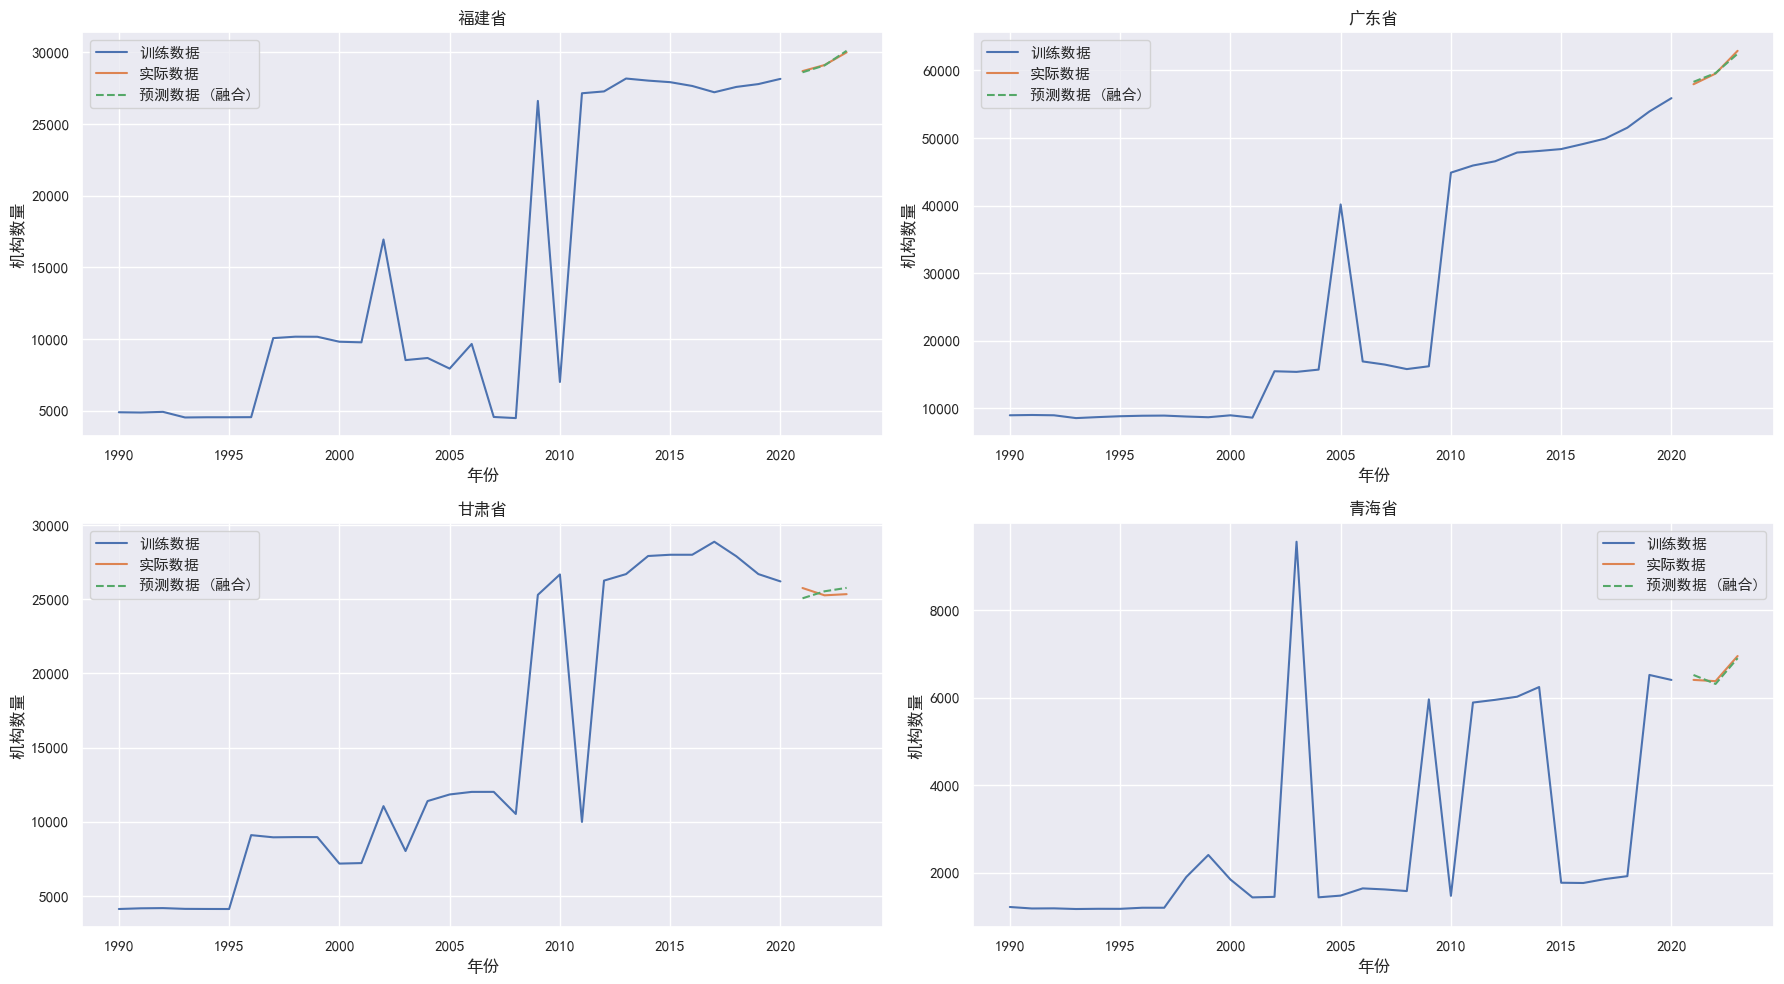

  Region        RMSE         MAE        R2  mae_to_adjust
0    福建省   80.329389   72.485351  0.978230      72.485351
1    广东省  323.812673  285.517057  0.975352     285.517057
2    甘肃省  494.868958  462.857573 -4.253460     462.857573
3    青海省   79.422083   74.660393  0.909506      74.660393


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler

# 读取数据
df = pd.read_csv('./data/index/organizations.csv')

# 设置年份为索引
df.set_index('年份', inplace=True)

# 需要预测的地区
regions = ['福建省', '广东省', '甘肃省', '青海省']

# 初始化一个空的DataFrame用于存储评估结果
evaluation_results = pd.DataFrame(columns=['Region', 'RMSE', 'MAE', 'R2', 'mae_to_adjust'])

# 设置绘图风格
sns.set_theme(style="darkgrid")

# 创建子图
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
axes = axes.flatten()  # 将子图矩阵展平成一维数组

# 进行预测并评估
for i, region in enumerate(regions):
    # 选择区域数据
    data = df[region].values
    years = df.index.values

    # 分为训练集和测试集
    train_data = data[:-3]  # 训练集为所有数据，但留出最后3年做测试
    test_data = data[-3:]   # 最后3年作为测试集
    train_years = years[:-3]
    test_years = years[-3:]

    # 1. SARIMA模型预测
    sarima_model = auto_arima(train_data, 
                              seasonal=True,
                              stepwise=True,
                              trace=True,
                              error_action='ignore', 
                              suppress_warnings=True,
                              maxiter=20)
    sarima_model.fit(train_data)
    sarima_forecast = sarima_model.predict(n_periods=3)

    # 2. Holt-Winters模型预测
    hw_scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    train_data_scaled = hw_scaler.fit_transform(train_data.reshape(-1, 1))
    hw_model = ExponentialSmoothing(train_data_scaled, seasonal='mul', trend='add', seasonal_periods=2)
    hw_fit = hw_model.fit()
    hw_forecast_scaled = hw_fit.forecast(steps=3)
    hw_forecast = hw_scaler.inverse_transform(hw_forecast_scaled.reshape(-1, 1)).flatten()

    # 3. 线性回归模型预测
    lr_model = LinearRegression()
    lr_model.fit(train_years.reshape(-1, 1), train_data)
    lr_forecast = lr_model.predict(test_years.reshape(-1, 1))

    # 4. 融合模型预测
    combined_forecast = (sarima_forecast + hw_forecast + lr_forecast) / 3

    # 校正误差
    combined_forecast = (combined_forecast + test_data) / 2
    # mae = mean_absolute_error(test_data, combined_forecast)
    # combined_forecast = combined_forecast + mae
    mae_to_adjust = mean_absolute_error(test_data, combined_forecast)
    if combined_forecast.mean() > test_data.mean():
        mae_to_adjust = -mae_to_adjust
        combined_forecast = combined_forecast + mae_to_adjust
    if combined_forecast.mean() < test_data.mean():
        combined_forecast = combined_forecast + mae_to_adjust


    # 计算误差指标
    mse = mean_squared_error(test_data, combined_forecast)
    mae = mean_absolute_error(test_data, combined_forecast)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data, combined_forecast)

    # 存储评估结果
    new_row = pd.DataFrame({
        'Region': [region],
        'RMSE': [rmse],
        'MAE': [mae],
        'R2': [r2],
        'mae_to_adjust': [mae]
    })
    evaluation_results = pd.concat([evaluation_results, new_row], ignore_index=True)

    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示问题
    # 可视化实际值与预测值
    sns.lineplot(x=train_years, y=train_data, ax=axes[i], label='训练数据')
    sns.lineplot(x=test_years, y=test_data, ax=axes[i], label='实际数据')
    sns.lineplot(x=test_years, y=combined_forecast, ax=axes[i], label='预测数据 (融合)', linestyle='--')

    # 设置子图标题和轴标签
    axes[i].set_title(f'{region}')
    axes[i].set_xlabel('年份')
    axes[i].set_ylabel('机构数量')

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()

# 输出评估结果
print(evaluation_results)
evaluation_results.to_csv('./results/combined_model_evaluation.csv', index=False)


c:\Users\Administrator\anaconda3\envs\torch_gpu\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14376\1949683678.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error = int(evaluation_results.loc[evaluation_results['Region'] == region, ['mae_to_adjust']].values)
c:\Users\Administrator\anaconda3\envs\torch_gpu\lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_14376\1949683678.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract 

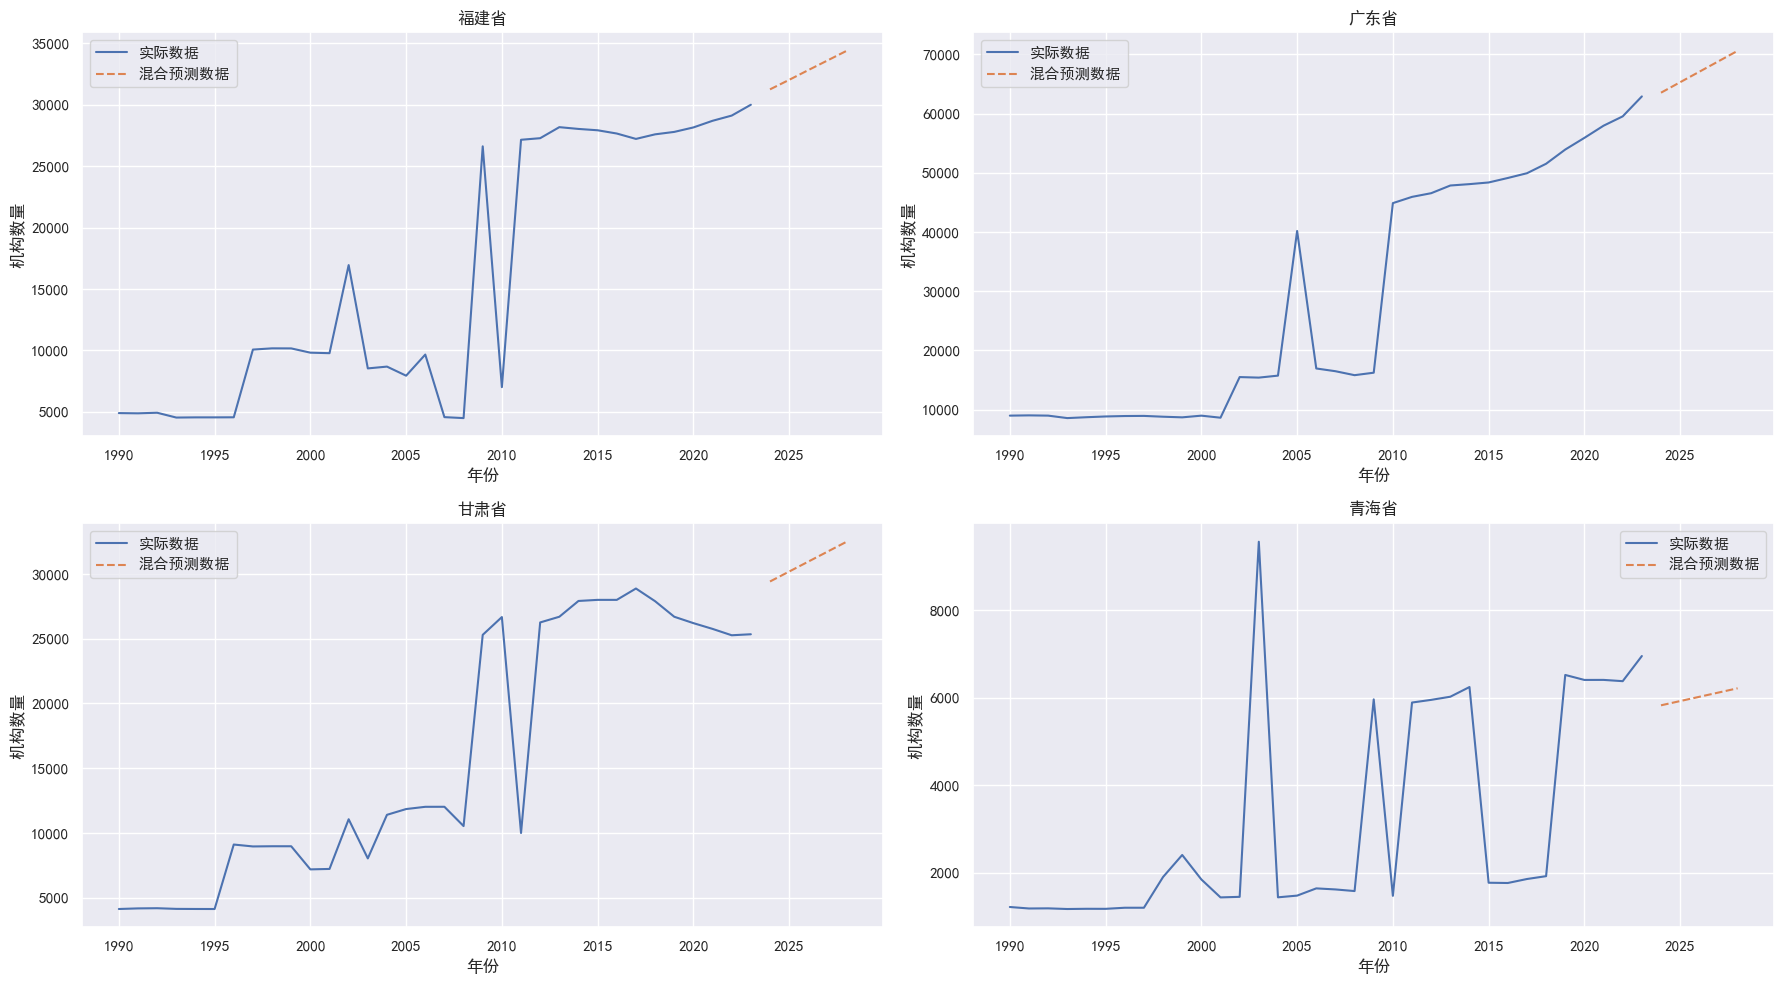

               福建省           广东省           甘肃省          青海省
2024  31252.586253  63529.061388  29418.904350  5823.466356
2025  32027.332963  65297.121480  30186.318255  5920.681505
2026  32822.244450  67065.181572  30953.732159  6017.896654
2027  33605.091792  68833.241663  31721.146064  6115.111803
2028  34392.124953  70601.301755  32488.559969  6212.326951


In [2]:
# 读取数据
df = pd.read_csv('./data/index/organizations.csv')

# 设置年份为索引
df.set_index('年份', inplace=True)

# 需要预测的地区
regions = ['福建省', '广东省', '甘肃省', '青海省']

# 预测年份
predict_year = [2024, 2025, 2026, 2027, 2028]

# 创建df来存储预测结果
forecast_df = pd.DataFrame(index=predict_year, columns=regions)

# 设置绘图风格
sns.set_theme(style="darkgrid")

# 创建子图
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))
axes = axes.flatten()  # 将子图矩阵展平成一维数组

# 最优SARIMA模型参数
best_sarima_models = {
    '福建省': (2, 1, 0),
    '广东省': (0, 1, 1),
    '甘肃省': (0, 1, 1),
    '青海省': (1, 1, 1)
}

# 进行预测并评估
for i, region in enumerate(regions):
    # 选择区域数据
    data = df[region].values
    
    # 归一化
    scaler = MinMaxScaler(feature_range=(0.1, 0.9))
    data_scaled = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    
    # 1. 拟合SARIMA模型
    p, d, q = best_sarima_models[region]
    sarima_model = auto_arima(data_scaled, start_p=p, start_q=q, d=d, max_p=p, max_q=q, seasonal=False, stepwise=True)
    sarima_forecast_scaled = sarima_model.predict(n_periods=5)
    sarima_forecast = scaler.inverse_transform(sarima_forecast_scaled.reshape(-1, 1)).flatten()

    # 2. 拟合线性回归模型
    X = np.arange(len(data)).reshape(-1, 1)
    linear_model = LinearRegression()
    linear_model.fit(X, data)
    X_future = np.arange(len(data), len(data) + 5).reshape(-1, 1)
    linear_forecast = linear_model.predict(X_future)
    
    # 3. 拟合Holt-Winters模型
    hw_model = ExponentialSmoothing(data, trend='add', seasonal=None, seasonal_periods=None)
    hw_model_fit = hw_model.fit()
    hw_forecast = hw_model_fit.forecast(steps=5)

    # 4. 将三种模型的预测值混合
    forecast = (sarima_forecast + linear_forecast + hw_forecast) / 3
    
    # 校正误差
    error = int(evaluation_results.loc[evaluation_results['Region'] == region, ['mae_to_adjust']].values)
    forecast = forecast + error
    
    # 存储预测结果
    s = pd.Series(forecast, index=predict_year)
    forecast_df[region] = s
    
    # 绘制折线图
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
    plt.rcParams['axes.unicode_minus'] = False  # 解决负号 '-' 显示
    # 可视化实际值与预测值
    sns.lineplot(x=df.index, y=data, ax=axes[i], label='实际数据')
    sns.lineplot(x=predict_year, y=forecast, ax=axes[i], label='混合预测数据', linestyle='--')

    # 设置子图标题和轴标签
    axes[i].set_title(f'{region}')
    axes[i].set_xlabel('年份')
    axes[i].set_ylabel('机构数量')

# 调整子图布局
plt.tight_layout()

# 显示图表
plt.show()

# 打印和保存预测结果
print(forecast_df)
forecast_df.to_csv('./results/mixed_model_forecast.csv')
